# Dipole coupled to a waveguide

In this notebook, we will try to optimize the coupling of a dipole source to a linear waveguide.

First, we import all the necessary packages.

In [3]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa, tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
from scipy import special, signal

# 0 = minimal output, 1 = a little , 2 = a lot, 3 = debuggig
verbosity=mp.Verbosity()
verbosity.meep=0
verbosity.mpb=0

GaAs = mp.Medium(index=3.45)

First, we setup the filter parameters that will be used in the discretization process as the optimization runs later on.

In [4]:
# filter parameters and mapping function:
minimum_length = 0.09  # minimum length scale (microns)
eta_i = 0.5            # blueprint (or intermediate) design field thresholding point (between 0 and 1)
eta_e = 0.55           # erosion design field thresholding point (between 0 and 1)
eta_d = 1-eta_e        # dilation design field thresholding point (between 0 and 1)
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length,eta_e)
print(filter_radius)

def mapping(x,eta,beta):
    # filter
    filtered_field = mpa.conic_filter(x,filter_radius,design_region_width,design_region_height,design_region_resolution)
    
    # projection
    projected_field = mpa.tanh_projection(filtered_field,beta,eta)
    
    # interpolate to actual materials
    return projected_field.flatten()

0.20124611797498096


Then, we define the necessary parameters for the optimization (e.g., computational cell size, design region size, sources, and geometry). Currently, we are using a GaAs 'cylinder' as a protective buffer to prevent any design changes too close to the QD.

In [5]:
# simulation parameters
resolution = 40
design_region_resolution = 20

waveguide_width = 0.4
waveguide_length = 1.5
design_region_width = 2.0
design_region_height = 2.0
buffer_radius = 0.1
pml_size = 1.0
pml_layers = [mp.PML(pml_size)]

Sx = 2*pml_size+design_region_width+waveguide_length
Sy = 2*pml_size+design_region_height+waveguide_length
cell_size = mp.Vector3(Sx,Sy)

fcen = 1/0.93
wavl_width = 0.01
nfreq = 50
df = fcen**2*wavl_width

freqs = np.array([fcen-df, fcen, fcen+df])  # really just concerned w/ performance at fcen, defined as array to match example (which use range of freqs)
fcen_index = freqs.size//2
src = mp.GaussianSource(frequency=fcen,fwidth=df)
source = [mp.Source(src,
                    component=mp.Ex,
                    center=mp.Vector3(0,0))]

Nx = int(design_region_resolution*design_region_width) + 1  # plus 1 needed to fix 'off by one' error in filter funcs(see git)
Ny = int(design_region_resolution*design_region_height) + 1
design_variables = mp.MaterialGrid(mp.Vector3(Nx,Ny),mp.air,GaAs,grid_type='U_MEAN')
design_region = mpa.DesignRegion(design_variables,
                                 volume=mp.Volume(center=mp.Vector3(0,0),
                                                  size=mp.Vector3(design_region_width, design_region_height, 0)))

# with Cylinder
geometry = [
    mp.Block(center=mp.Vector3(y=Sy/4), material=GaAs, size=mp.Vector3(waveguide_width, Sy/2, 0)),  # vertical waveguide
    mp.Block(center=design_region.center, size=design_region.size, material=design_variables), # design region
    mp.Block(center=design_region.center, size=design_region.size, material=design_variables,
             e1=mp.Vector3(x=-1), e2=mp.Vector3(y=1)), # enforce mirror symmetry about x=0 plane
    mp.Cylinder(center=design_region.center, material=GaAs, radius=buffer_radius) # buffer region to protect QD
]
'''
# without Cylinder, opt just runs forever... why?
geometry = [
    mp.Block(center=mp.Vector3(y=Sy/4), material=GaAs, size=mp.Vector3(waveguide_width, Sy/2, 0)),  # vertical waveguide
    mp.Block(center=design_region.center, size=design_region.size, material=design_variables), # design region
    mp.Block(center=design_region.center, size=design_region.size, material=design_variables,
             e1=mp.Vector3(x=-1), e2=mp.Vector3(y=1)) # enforce mirror symmetry about x=0 plane
]
'''
sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=source,
                    resolution=resolution)

Afterward, set up the actual optimization problem by defining the objective function, J. Here we simply want to maximize mode overlap to the single waveguide in the y-direction. So far, meep objective functions are pretty much restricted to this objective, but it should be all we need for our purposes.

In [6]:
# Optimization Problem Setup
mon_center = mp.Vector3(0, design_region_height-pml_size,0)
TE_top = mpa.EigenmodeCoefficient(sim,mp.Volume(center=mon_center,size=mp.Vector3(x=3*waveguide_width)),mode=1)
ob_list = [TE_top]

def J(alpha):
    return npa.abs(alpha)**2

opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=J,
    objective_arguments=ob_list,
    design_regions=[design_region],
    frequencies=freqs)

As before, we'll visualize everything to ensure our monitors, boundary layers, and geometry are drawn correctly.

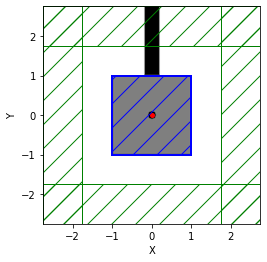

In [7]:
# Visualize initial geometry w/ monitor to ensure everything is correct
x = 0.5*np.ones((Nx*Ny,))
opt.update_design([mapping(x, eta_i, 1e3)])

# plot flux box and design region
opt.plot2D(True)

We can now define a cost function wrapper that we can feed into our `nlopt` optimizer. `nlopt` expects a python function where the gradient is passed in place. In addition, we'll update a list with every objective function call so we can track the cost function evolution each iteration.

Notice the `opt` adjoint solver object requires we pass our numpy array of design parameters within an additional list. This is because the adjoint solver can solve for multiple design regions simultaneously. It's useful to break up each region's parameters into indvidual numpy arrays. In this simple example, we only have one design region.

We took the plotting commands below from the Filtered_Waveguide_Bend notebook.

In [8]:
evaluation_history = []
sensitivity = [0]
cur_iter = [0]
# currently have to return/append values[fcen_index] to avoid dealing with a list of arrays during analysis
def f(v, gradient, cur_beta):
    print("Current iteration: {}".format(cur_iter[0]+1))
    f0, dJ_du = opt([mapping(v, eta_i, cur_beta)])
    if gradient.size > 0:
        gradient[:] = tensor_jacobian_product(mapping,0)(v, eta_i, cur_beta, np.sum(dJ_du, axis=1))
    evaluation_history.append(np.real(f0)[fcen_index])
    sensitivity[0] = dJ_du
    
    plt.figure()
    ax = plt.gca()
    opt.plot2D(False,ax=ax,plot_sources_flag=False,plot_monitors_flag=False,plot_boundaries_flag=False)
    ax.axis('off')
    plt.show()
    
    cur_iter[0] = cur_iter[0] + 1
    val = (np.real(f0)).astype(float) # needed to cast to float to prevent nlopt arg. error
    return val[fcen_index]
    #return val

Now we can set up the actual optimizer engine. We'll select the Method of Moving Asymptotes because it's a gradient based method that allows us to specify linear and nonlinear constraints. For now, we'll simply bound our parameters between 0 and 1 and use a uniform initial permittivity distribution of 0.5.

We'll tell our solver to maximize (rather than minimize) our cost function, since we are trying to maximize coupling to fundamental waveguide mode.

Here, the beta parameters and update factor control the total number of iterations. Starting with cur_beta=1 is effectively using no discretization, and after the number of iteration given by 'update_factor,' beta is set to double. It repeats the process for a given number of betas defined by 'num_betas'. For example, with an update factor of 12 and 6 different betas, there will be 72 iterations total.

Current iteration: 1
Starting forward run...
Starting adjoint run...
Calculating gradient...


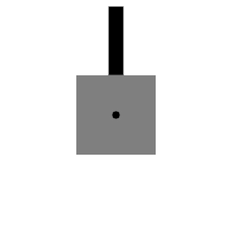

Current iteration: 2
Starting forward run...
Starting adjoint run...
Calculating gradient...


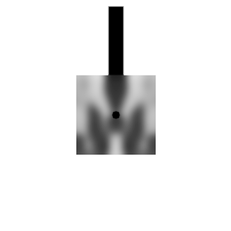

Current iteration: 3
Starting forward run...
Starting adjoint run...
Calculating gradient...


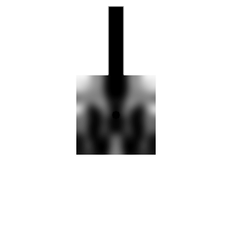

Current iteration: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


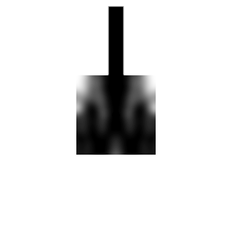

Current iteration: 5
Starting forward run...
Starting adjoint run...
Calculating gradient...


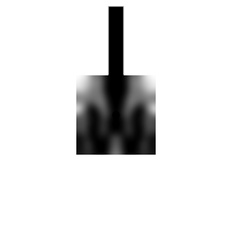

Current iteration: 6
Starting forward run...
Starting adjoint run...
Calculating gradient...


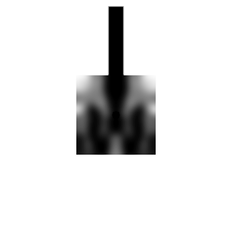

Current iteration: 7
Starting forward run...
Starting adjoint run...
Calculating gradient...


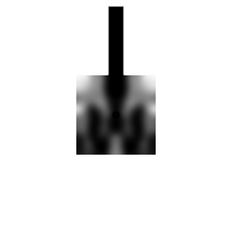

Current iteration: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


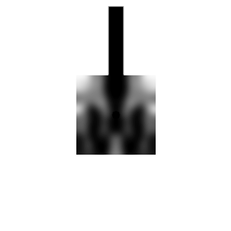

Current iteration: 9
Starting forward run...
Starting adjoint run...
Calculating gradient...


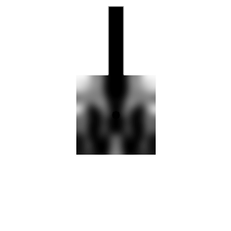

Current iteration: 10
Starting forward run...
Starting adjoint run...
Calculating gradient...


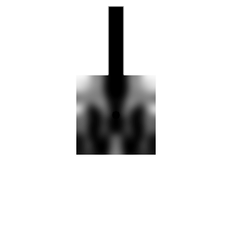

Current iteration: 11
Starting forward run...
Starting adjoint run...
Calculating gradient...


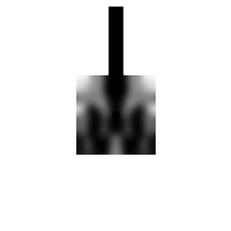

Current iteration: 12
Starting forward run...
Starting adjoint run...
Calculating gradient...


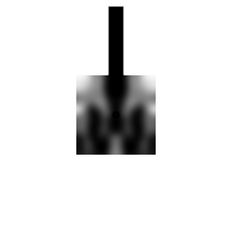

Current iteration: 13
Starting forward run...
Starting adjoint run...
Calculating gradient...


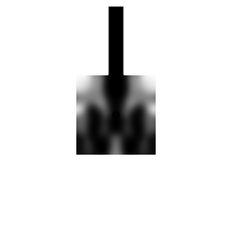

Current iteration: 14
Starting forward run...
Starting adjoint run...
Calculating gradient...


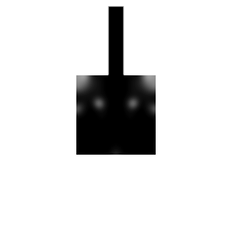

Current iteration: 15
Starting forward run...
Starting adjoint run...
Calculating gradient...


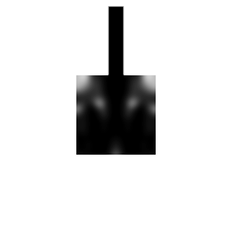

Current iteration: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


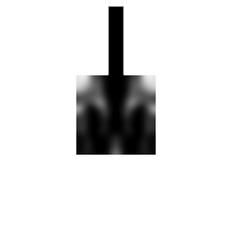

Current iteration: 17
Starting forward run...
Starting adjoint run...
Calculating gradient...


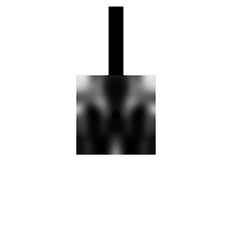

Current iteration: 18
Starting forward run...
Starting adjoint run...
Calculating gradient...


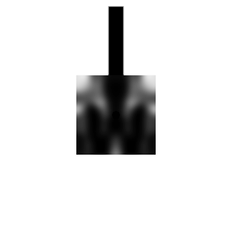

Current iteration: 19
Starting forward run...
Starting adjoint run...
Calculating gradient...


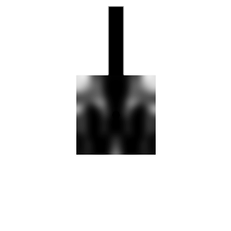

Current iteration: 20
Starting forward run...
Starting adjoint run...
Calculating gradient...


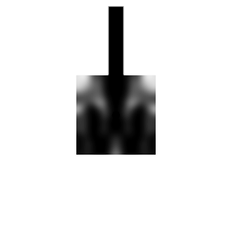

Current iteration: 21
Starting forward run...
Starting adjoint run...
Calculating gradient...


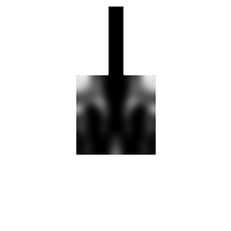

Current iteration: 22
Starting forward run...
Starting adjoint run...
Calculating gradient...


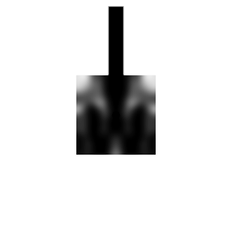

Current iteration: 23
Starting forward run...
Starting adjoint run...
Calculating gradient...


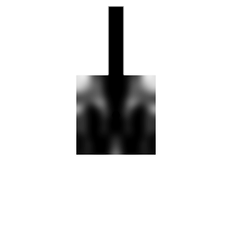

Current iteration: 24
Starting forward run...
Starting adjoint run...
Calculating gradient...


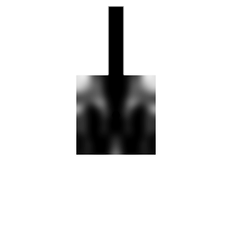

Current iteration: 25
Starting forward run...
Starting adjoint run...
Calculating gradient...


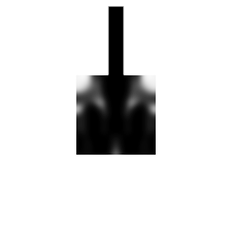

Current iteration: 26
Starting forward run...
Starting adjoint run...
Calculating gradient...


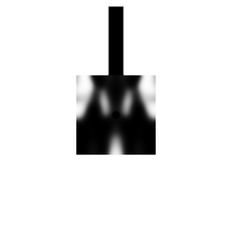

Current iteration: 27
Starting forward run...
Starting adjoint run...
Calculating gradient...


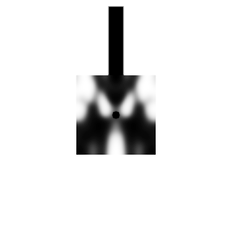

Current iteration: 28
Starting forward run...
Starting adjoint run...
Calculating gradient...


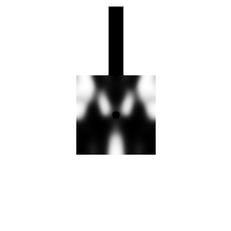

Current iteration: 29
Starting forward run...
Starting adjoint run...
Calculating gradient...


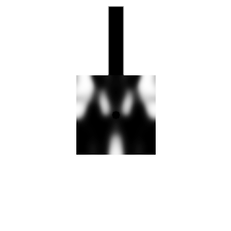

Current iteration: 30
Starting forward run...
Starting adjoint run...
Calculating gradient...


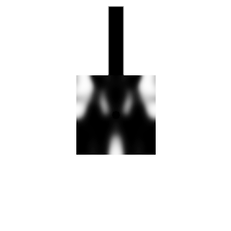

Current iteration: 31
Starting forward run...
Starting adjoint run...
Calculating gradient...


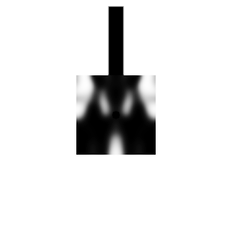

Current iteration: 32
Starting forward run...
Starting adjoint run...


In [ ]:
# Run optimization
algorithm = nlopt.LD_MMA
n = Nx * Ny

# initial eps dist:
x = np.ones((n,)) * 0.5

cur_beta = 1
beta_scale=2
num_betas=6
update_factor=12

lb = np.zeros((n,))
ub = np.ones((n,))

for i in range(num_betas):
    solver = nlopt.opt(algorithm, n)
    solver.set_lower_bounds(lb)
    solver.set_upper_bounds(ub)
    solver.set_max_objective(lambda a,g:f(a,g,cur_beta))
    solver.set_maxeval(update_factor)
    x[:] = solver.optimize(x)
    cur_beta = cur_beta*beta_scale

Now that the solver is done running, we can evaluate our progress by viewing the objective function history.

In [ ]:
# FOM vs Iteration plot
print(np.shape(evaluation_history))
print(type(evaluation_history))
plt.figure()
plt.plot(evaluation_history,'o-')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('FOM')
plt.title('Performance at %d Resolution;' % resolution)
plt.show()

We can update our optimization object and visualize the results.

In [ ]:
# Visualize final design
opt.update_design([mapping(x, eta_i, 1e3)])
opt.plot2D(True,plot_monitors_flag=False,output_plane=mp.Volume(center=(0,0,0),size=(3,3,0)))
#plt.axis("off");

We can also visualize the sensitivity to see which geometric areas are most sensitive to perturbations.

In [ ]:
#plt.imshow(np.rot90(np.squeeze(np.abs(sensitivity[0].reshape(Nx,Ny)))));

# This is currently an issue. The dimensions of the input sensitivity array don't make the most sense. Have to do some array manipulation to get this piece working again
# not the *most* important issue to address though

#plt.imshow(np.rot90(np.squeeze(sensitivity[0].reshape(Nx,Ny))));
#plt.colorbar()

Next, we set up flux monitors for the normalization simulation by forming a box around the source to monitor the output power.

In [ ]:
# make sure these monitors are consistent with design region size increase
xp_cen = mp.Vector3(design_region_width-pml_size,0,0)
xm_cen = mp.Vector3(-design_region_width+pml_size,0,0)
yp_cen = mp.Vector3(0,design_region_height-pml_size,0)
ym_cen = mp.Vector3(0,-design_region_height+pml_size,0)

x_size = mp.Vector3(0, design_region_height+pml_size/2,0)
y_size = mp.Vector3(design_region_width+pml_size/2,0,0)

Pxp_mon = mp.FluxRegion(center=xp_cen, size=x_size)                            
xp_flux = sim.add_flux(fcen, df, nfreq, Pxp_mon)
Pxm_mon = mp.FluxRegion(center=xm_cen, size=x_size)                            
xm_flux = sim.add_flux(fcen, df, nfreq, Pxm_mon)
Pyp_mon = mp.FluxRegion(center=yp_cen, size=y_size)                            
yp_flux = sim.add_flux(fcen, df, nfreq, Pyp_mon)
Pym_mon = mp.FluxRegion(center=ym_cen, size=y_size)                            
ym_flux = sim.add_flux(fcen, df, nfreq, Pym_mon)

sim.plot2D()

In [ ]:
# Run sim to calculate coupling efficiencies
sim.restart_fields()
sim.run(until_after_sources=mp.stop_when_fields_decayed(50,mp.Ex,yp_cen,1e-3))
print('done')

# Grab total output flux to normalize modal power
Pxp = np.array(mp.get_fluxes(xp_flux))
Pxm = np.array(mp.get_fluxes(xm_flux))
Pyp = np.array(mp.get_fluxes(yp_flux))
Pym = np.array(mp.get_fluxes(ym_flux))
Ptotal = (Pxp-Pxm)+(Pyp-Pym)
#print(Ptotal)
# looking at fundamental mode
res = sim.get_eigenmode_coefficients(yp_flux,[1],eig_parity=mp.NO_PARITY)
incident_coeffs = np.array(res.alpha)

plt.figure()
wavl = 1/np.array(mp.get_flux_freqs(xm_flux))
modal_power = abs(incident_coeffs)**2

# Plot normalized efficiency vs wavlength
plt.figure()
plt.plot(wavl*1000,modal_power[0,:,0]/Ptotal)
plt.title('Performance at %d resolution (With Cylinder & No Mask)' % (resolution))
plt.xlabel('Wavelength (nm)')
plt.ylabel('Couping Efficiency')
plt.show()

In [ ]:
# Run w/ CW source and plot field(Ex) overlay
cw_source = [mp.Source(mp.ContinuousSource(frequency = fcen),
                    component = mp.Ex,
                    center = design_region.center,
                    size = mp.Vector3(0,0,0))]
sim.change_sources(cw_source)
sim.run(until=400)
#sim.plot2D(plot_monitors_flag=False)
sim.plot2D(fields=mp.Ex, plot_monitors_flag=False)